In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
%matplotlib inline
import dask.dataframe as dd
from tqdm import tqdm 
import warnings
warnings.filterwarnings(action = 'once')
from statsmodels.tsa.stattools import adfuller
from numpy import log

In [2]:
df = pd.read_csv("Symbol0 2.csv")

In [3]:
result = adfuller(df.iloc[:, 1].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -24.109618
p-value: 0.000000


In [21]:
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.iloc[:, 1].values); axes[0, 0].set_title('Original Series')
sm.graphics.tsa.plot_acf(df.iloc[:, 1].values, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(np.diff(df.iloc[:, 1].values)); axes[1, 0].set_title('1st Order Differencing')
sm.graphics.tsa.plot_acf(np.diff(df.iloc[:, 1].values), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(np.diff(np.diff(df.iloc[:, 1].values))); axes[2, 0].set_title('2nd Order Differencing')
sm.graphics.tsa.plot_acf(np.diff(np.diff(df.iloc[:, 1].values)), ax=axes[2, 1])

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 100
fig_size[1] = 200
plt.rcParams["figure.figsize"] = fig_size
plt.show()

KeyboardInterrupt: 

In [7]:
from pmdarima.arima.utils import ndiffs
y = df.iloc[:, 1].values

/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [9]:
## Adf Test
ndiffs(y, test='adf')  # 2

0

In [12]:
# KPSS test
ndiffs(y, test='kpss')  # 0

0

In [11]:
# PP test:
ndiffs(y, test='pp')  # 2

0

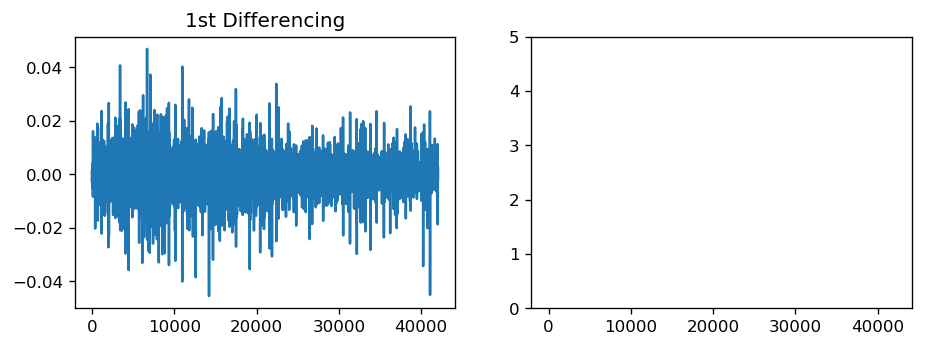

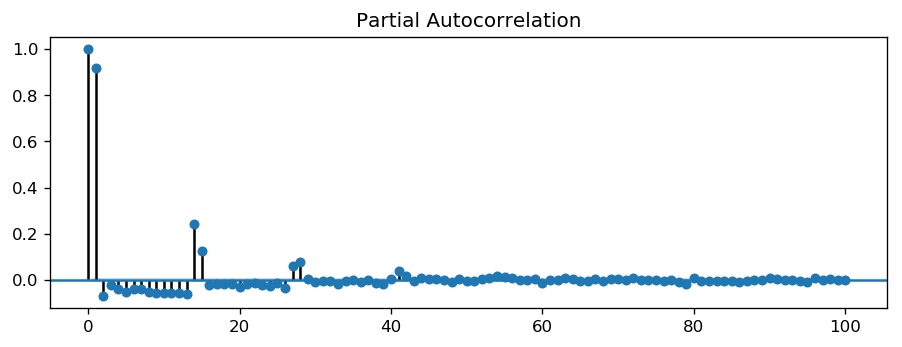

In [33]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(np.diff(df.iloc[:, 1].values)); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
sm.graphics.tsa.plot_pacf(df.iloc[:, 1].values, lags=100)

plt.show()

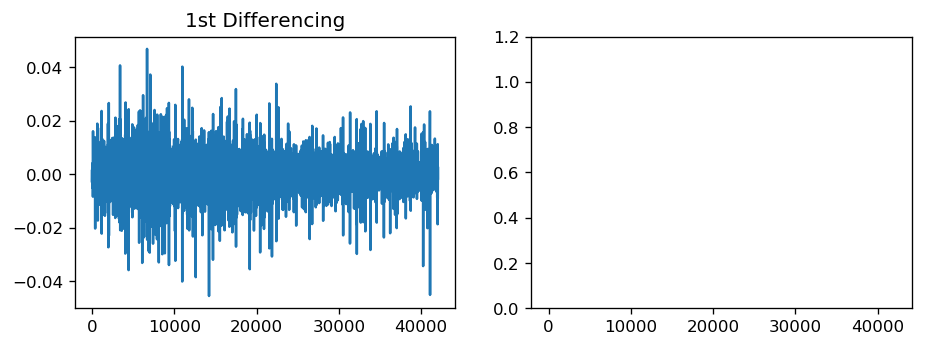

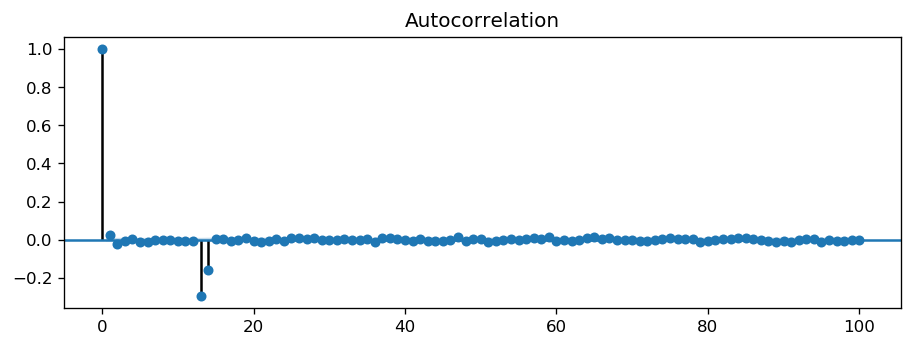

In [37]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(np.diff(df.iloc[:, 1].values)); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
sm.graphics.tsa.plot_acf(np.diff(df.iloc[:, 1].values), lags=100)

plt.show()

In [38]:
from statsmodels.tsa.arima_model import ARIMA

# 2,1,1 ARIMA Model
model = ARIMA(df.iloc[:, 1].values, order=(2,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                42053
Model:                 ARIMA(2, 1, 1)   Log Likelihood              178731.708
Method:                       css-mle   S.D. of innovations              0.003
Date:                Thu, 09 Jan 2020   AIC                        -357453.415
Time:                        21:44:39   BIC                        -357410.182
Sample:                             1   HQIC                       -357439.763
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.973e-08   4.56e-07      0.087      0.931   -8.55e-07    9.34e-07
ar.L1.D.y      0.9795      0.005    198.544      0.000       0.970       0.989
ar.L2.D.y     -0.0678      0.005    -13.798      0.0

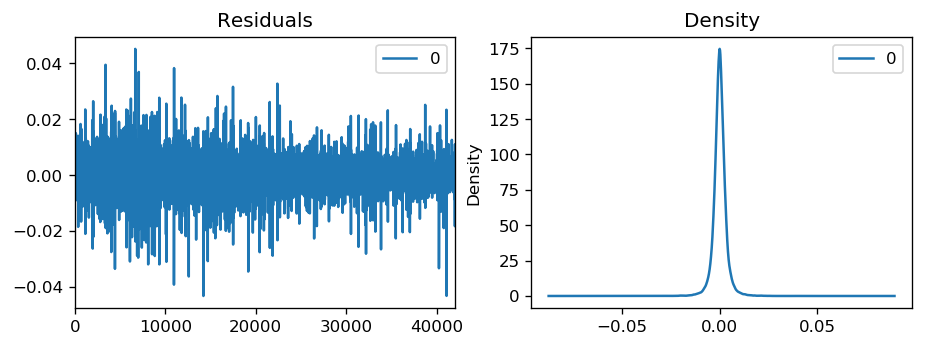

In [39]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

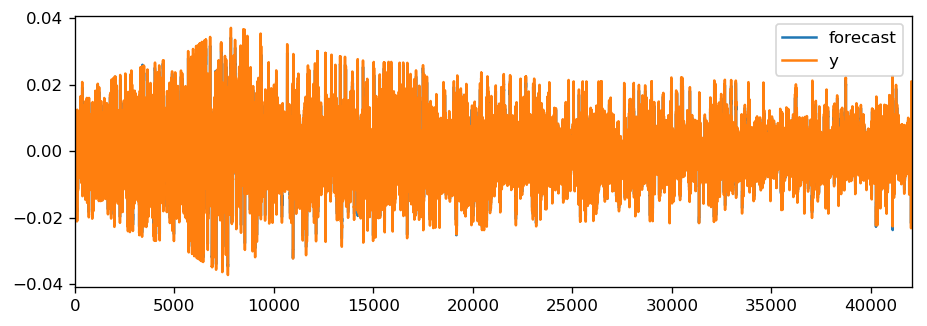

In [40]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

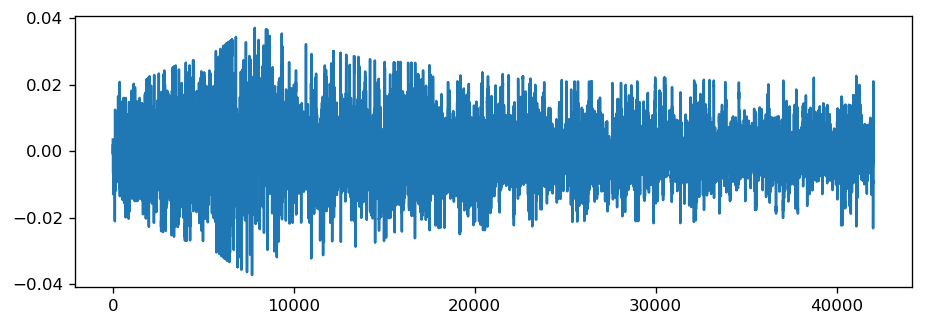

In [41]:
plt.plot(df.iloc[:, 1].values)

In [42]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = df.iloc[:, 1].values[:40000]
test = df.iloc[:, 1].values[40000:]

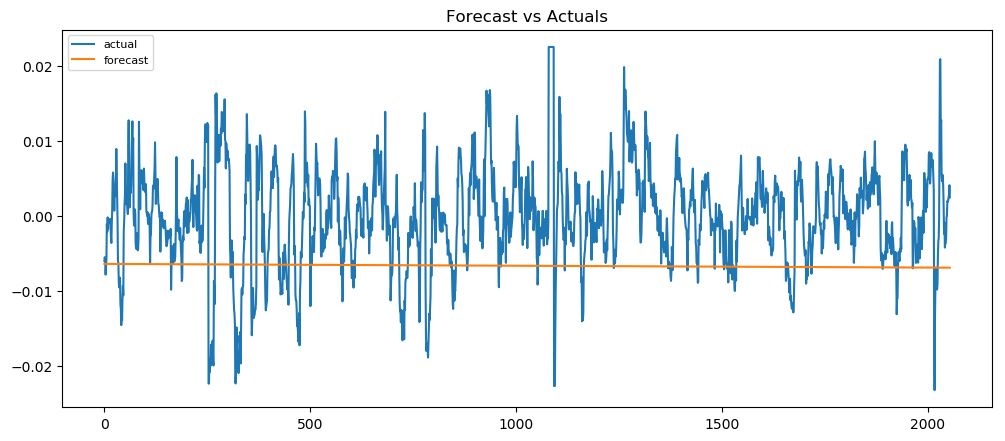

In [53]:
# Build Model
model = ARIMA(train, order=(2, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(len(df.iloc[:, 1]) - 40000, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc)
lower_series = pd.Series(conf[:, 0])
upper_series = pd.Series(conf[:, 1])

# Plot
plt.figure(figsize=(12,5), dpi=100)
# plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

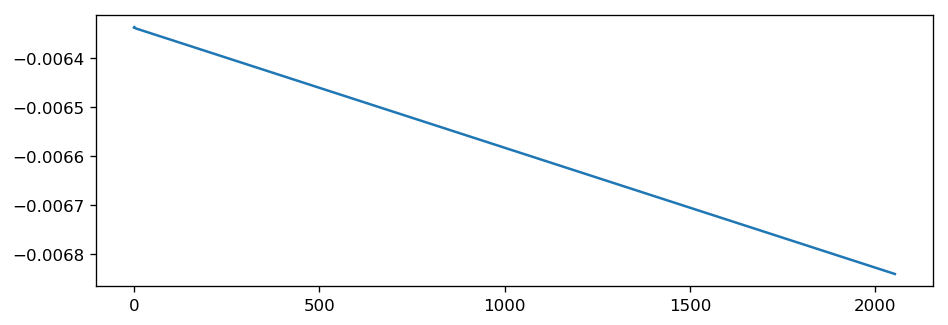

In [52]:
plt.plot(fc_series, label='forecast')
plt.show()

In [55]:
import pmdarima as pm
model = pm.auto_arima(df.iloc[:, 1].values, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 0); AIC=-357526.229, BIC=-357491.642, Fit time=5.223 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 0); AIC=-279483.775, BIC=-279466.482, Fit time=3.983 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 0); AIC=-357334.712, BIC=-357308.772, Fit time=5.582 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 0); AIC=-316600.962, BIC=-316575.022, Fit time=14.121 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 0); AIC=-279481.614, BIC=-279472.967, Fit time=1.143 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 0); AIC=-357591.248, BIC=-357548.014, Fit time=4.048 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 0, 0); AIC=-357535.828, BIC=-357501.242, Fit time=4.667 seconds
Fit ARIMA: order=(3, 0, 1) seasonal_order=(0, 0, 0, 0); AIC=-357534.186, BIC=-357482.306, Fit time=13.314 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 0); AIC=-357489.459, BIC=-357437.578, Fit 

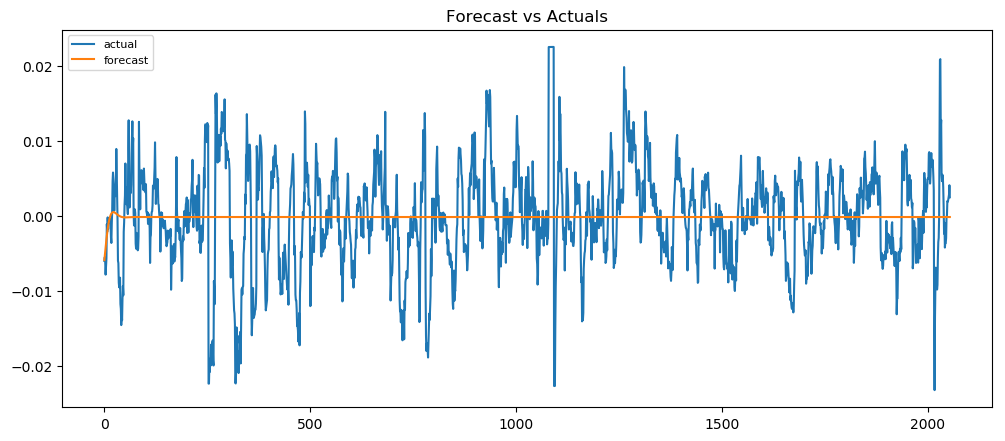

In [57]:
# Build Model
model = ARIMA(train, order=(3, 0, 2))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(len(df.iloc[:, 1]) - 40000, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc)
lower_series = pd.Series(conf[:, 0])
upper_series = pd.Series(conf[:, 1])

# Plot
plt.figure(figsize=(12,5), dpi=100)
# plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [58]:
# Forecast
n_periods = 2000
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.value), len(df.value)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.value)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()

TypeError: predict() got an unexpected keyword argument 'n_periods'